# Entorhinal Modularisaion - Analysis of Learnt Reps - 21st August 2024

Here we try to use Kyle's metrics to see if things are moduarised or not.

In [418]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import vmap, value_and_grad, grad, jit, random
import jax.nn as jnn
from mpl_toolkits.mplot3d import Axes3D
import math
import scipy
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif

def entropy(x):
    _, counts = np.unique(x, return_counts=True, axis=0)
    p_x = counts / x.shape[0]
    return -np.sum(p_x * np.log2(p_x))

def conditional_entropy(x, y):
    """H(X|Y) = H(X, Y) - H(Y)"""
    H_xy = entropy(np.concatenate([x, y], axis=1))
    H_y = entropy(y)
    return H_xy - H_y

def compute_ncmi(s, z, n_neighbors=3):
    """
    Normalized conditional mutual information between sources s and latents z.
    The [i, j] element is the conditional mutual information between the i-th source and the j-th latent 
    given the rest of the sources, normalized by the conditional entropy of the i-th source given the rest
    of the sources.
    I(z_j; s_i | s_{-i}) = I(z_j; s_i, s_{-i}) - I(z_j; s_{-i}) = I(z_j; s) - I(z_j; s_{-i})
    NCMI[i, j] = I(z_j; s_i | s_{-i}) / H(s_i | s_{-i})
    """
    
    ds = s.shape[1]
    dz = z.shape[1]
    
    I_z_j_and_s_joint = np.empty(shape=(dz,))
    s_joint = LabelEncoder().fit_transform([str(s_sample) for s_sample in s])
    for j in range(dz):
        I_z_j_and_s_joint[j] = mutual_info_classif(z[:, j].reshape(-1, 1), s_joint, n_neighbors=n_neighbors).squeeze()
    
    ncmi = np.empty(shape=(ds, dz))
    for i in range(ds):
        s_rest = s[:, np.arange(ds) != i]
        s_rest_str = LabelEncoder().fit_transform([str(s_sample) for s_sample in s_rest])
        for j in range(dz):
            I_z_j_and_s_rest = mutual_info_classif(z[:, j].reshape(-1, 1), s_rest_str, n_neighbors=n_neighbors).squeeze()
            ncmi[i, j] = I_z_j_and_s_joint[j] - I_z_j_and_s_rest
        H_s_i_given_s_rest = conditional_entropy(s[:, i].reshape(-1, 1), s_rest)
        ncmi[i, :] /= H_s_i_given_s_rest
    return ncmi

def compute_cinfomec(s, z):
    """
    Compute CInfoM, CInfoC, and InfoE between discrete sources s and continuous latents z.
    s: np.ndarray, shape=(n_samples, n_sources)
    z: np.ndarray, shape=(n_samples, n_latents)
    
    Inactive latents are heuristically identified by their range being less than a proportion of the range of the most active latent. Inactive latents are ignored in the computation of CInfoM and CInfoC.
    """
    ncmi = compute_ncmi(s, z)
    ncmi[ncmi < 0] = 0
    
    z_ranges = np.max(z, axis=0) - np.min(z, axis=0)
    max_z_range = np.max(z_ranges)
    z_active = z_ranges > 0.1 * max_z_range
    
    ds = s.shape[1]
    ncmi_active = ncmi[:, z_active]
    dz_active = np.sum(z_active)
    if dz_active == 0:
        return {
            'CInfoM': 0,
            'CInfoC': 0,
            # 'InfoE': 0,
            'NCMI': ncmi,
            'z_active': z_active
        }
    cinfom = (np.mean(np.max(ncmi_active, axis=0) / np.sum(ncmi_active, axis=0)) - 1 / ds) / (
                1 - 1 / ds)
    cinfoc = (np.mean(np.max(ncmi_active, axis=1) / np.sum(ncmi_active, axis=1)) - 1 / dz_active) / (
                1 - 1 / dz_active)
    # infoe = infomec.compute_infoe(s, z, 'discrete', 'continuous')
    return {
        'CInfoM': cinfom,
        'CInfoC': cinfoc,
        # 'InfoE': infoe,
        'NCMI': ncmi,
        'z_active': z_active
    }

In [419]:
from metrics import compute_linear_metrics


Three cases:
1) Totally random reward position
2) Half random, half in one position
3) Totally in one position
4) Flexible prob of random vs. fixed

In [657]:
sampling_choice = 2 # Correspond to 1, 2, and 3 above.
prob = 9
if sampling_choice == 1:
    params_best = np.load('./data/PI_Learnt_Reps/random_2.npy', allow_pickle = True)[()]
elif sampling_choice == 2:
    params_best = np.load('./data/PI_Learnt_Reps/half_half_2.npy', allow_pickle = True)[()]
elif sampling_choice == 3:
    params_best = np.load('./data/PI_Learnt_Reps/fixed_2.npy', allow_pickle = True)[()]
else:
    params_best = np.load(f'./data/PI_Learnt_Reps/prop_{prob}_1.npy', allow_pickle = True)[()]

N = params_best['W'].shape[1] # Number of neurons

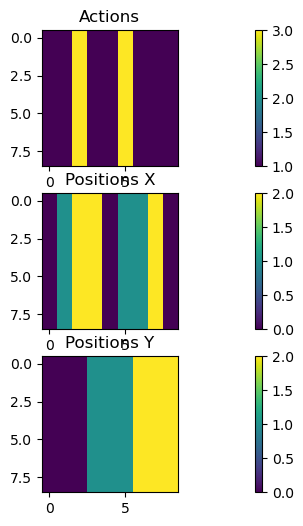

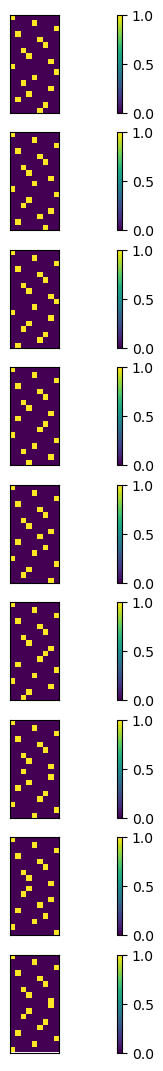

In [658]:
L = 3 # Size of room

all_positions = np.array([[i,j] for i in range(L) for j in range(L)])
if sampling_choice == 3:
    object_positions = np.array([[0,1], [0,1]])
    num_samples = 2
else:
    num_samples = 9
    object_positions = all_positions.T

labels = np.zeros([2*L**2, L, L, num_samples]) # This is the output matrix, x and y current position, and displacement to reward, in each position, for each room

for room in range(num_samples):
    object_position = object_positions[:,room]
    for l_x in range(L):
        for l_y in range(L):
            # First ensure one set of labels encodes position
            one_hot_ind = np.where(np.logical_and(all_positions[:,0] == l_x, all_positions[:,1] == l_y))[0]
            labels[one_hot_ind, l_x, l_y, room] = 1

            # Now go through and calculate shortest action to object
            distance = object_position - np.array([l_x, l_y])
            distance[distance > L] = distance[distance > L] - L
            distance[distance < 0] = distance[distance < 0] + L
            one_hot_ind = np.where(np.logical_and(all_positions[:,0] == distance[0], all_positions[:,1] == distance[1]))[0]
            labels[L**2+one_hot_ind, l_x, l_y, room] = 1


# Finally we create the network's one-hot inputs for these rooms.
inputs = np.zeros([L**2, num_samples])
for d in range(num_samples):
    pos = object_positions[:,d]
    one_hot_code_ind = np.where(np.logical_and(all_positions[:,0] == pos[0,None], all_positions[:,1] == pos[1,None]))[0]
    inputs[one_hot_code_ind, d] = 1

# Create random data to feed the network
T = L**2 # Length of each trajectory

# Set up step matrix
steps = np.zeros([4, 2])
steps[0,0] = -1
steps[1,0] = 1
steps[2,1] = -1
steps[3,1] = 1

steoreotyped_actions = np.tile([1,1,L,1,1,L,1,1,1], [num_samples,1]).astype(int).T

# Given actions, compute the positions
positions = np.zeros([2, T, num_samples])
for t in range(1, T):
    positions[:,t,:] = np.mod(positions[:,t-1,:] + steps[steoreotyped_actions[t-1,:]].T, L) # This is for periodic
positions = positions.astype(int)

network_signals = np.zeros([2*L**2,T,num_samples])
for d in range(num_samples):
    for t in range(T):
        for input_dim in range(2*L**2):
            network_signals[input_dim,t,d] = labels[input_dim, positions[0,t,d], positions[1,t,d],d]
        
plt.figure(figsize = (20, 6))
plt.subplot(3,1,1)
plt.imshow(steoreotyped_actions.T)
plt.title('Actions')
plt.xticks()
plt.yticks()
plt.colorbar()

plt.subplot(3,1,2)
plt.imshow(positions[0,:,:].T)
plt.title('Positions X')
plt.xticks()
plt.yticks()
plt.colorbar()

plt.subplot(3,1,3)
plt.imshow(positions[1,:,:].T)
plt.title('Positions Y')
plt.xticks()
plt.yticks()
plt.colorbar()

plt.figure(figsize = (15,15))
plot_rows = 10
plot_cols = int(num_samples/plot_rows)+1
for room in range(num_samples):
    plt.subplot(plot_rows, plot_cols, room+1)
    plt.imshow(network_signals[:,:,room])
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()

In [659]:
def generate_rep(params, inputs, actions):
    # Inputs dim x traj length x rooms, actions traj length x rooms
    g = jnp.zeros([N, T, num_samples])
    g = g.at[:,0,:].set(params['I'][:,:-1]@inputs[:,:] + params['I'][:,-1][:,None])

    # For rest we just recurrently go around.
    for t in range(1,T):
        g = g.at[:,t,:].set(jnp.einsum('ijk,ki->ji', params['W'][actions[t-1],:,:-1],g[:,t-1,:]) + params['W'][actions[t-1],:,-1].T)
    return g

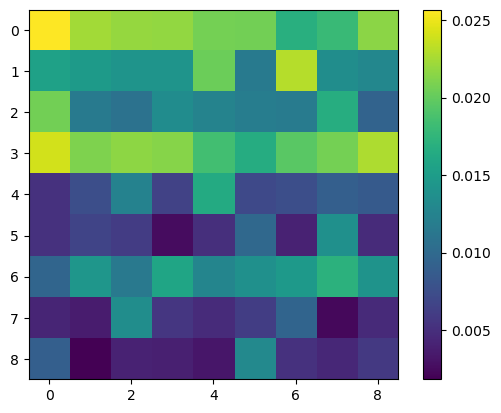

In [660]:
g = generate_rep(params_best, inputs, steoreotyped_actions)
plt.imshow(g[55,:,:])
plt.colorbar()

In [661]:
network_signals.shape

(18, 9, 9)

In [662]:
s_full = np.reshape(network_signals, [network_signals.shape[0], (L**2)*num_samples]).astype(int).T
z = np.reshape(g, [N, (L**2)*num_samples]).T
s_full.shape[0]

81

In [663]:
one_hot_to_num_array = np.array([i for i in range(L**2)])

In [664]:
# Let's try turning into 1D code?
s = np.zeros([s_full.shape[0], 2])
for data in range(s.shape[0]):
    s[data,0] = np.dot(s_full[data,0:L**2], one_hot_to_num_array)
    s[data,1] = np.dot(s_full[data,L**2:], one_hot_to_num_array)

s = s.astype(int)
s

array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [0, 4],
       [0, 5],
       [0, 6],
       [0, 7],
       [0, 8],
       [3, 6],
       [3, 7],
       [3, 8],
       [3, 0],
       [3, 1],
       [3, 2],
       [3, 3],
       [3, 4],
       [3, 5],
       [6, 3],
       [6, 4],
       [6, 5],
       [6, 6],
       [6, 7],
       [6, 8],
       [6, 0],
       [6, 1],
       [6, 2],
       [7, 5],
       [7, 3],
       [7, 4],
       [7, 8],
       [7, 6],
       [7, 7],
       [7, 2],
       [7, 0],
       [7, 1],
       [1, 2],
       [1, 0],
       [1, 1],
       [1, 5],
       [1, 3],
       [1, 4],
       [1, 8],
       [1, 6],
       [1, 7],
       [4, 8],
       [4, 6],
       [4, 7],
       [4, 2],
       [4, 0],
       [4, 1],
       [4, 5],
       [4, 3],
       [4, 4],
       [5, 7],
       [5, 8],
       [5, 6],
       [5, 1],
       [5, 2],
       [5, 0],
       [5, 4],
       [5, 5],
       [5, 3],
       [8, 4],
       [8, 5],
       [8, 3],
       [8,

In [665]:
linear_metrics = compute_linear_metrics(s, z, 'continuous', 'continuous')

In [666]:
def plot_mi_heatmap(results, k):
    mi = results[k]
    mi = mi[:, results['z_active']]
    fig, ax = plt.subplots(figsize=(0.5 * (mi.shape[1] + 1), 0.5 * (mi.shape[0] + 1)))
    sns.heatmap(
        mi, ax=ax, annot=False, fmt='.2f', square=True, vmin=0, vmax=1, cbar=True,
        annot_kws={'fontsize': 8},
        xticklabels=[rf'$\mathbf{{z}}_{{{i}}}$' for i in results['z_active'].nonzero()[0]],
        yticklabels=[rf'$\mathbf{{s}}_{{{i}}}$' for i in range(mi.shape[0])],
        rasterized=True
    )
    ax.set_title(k)

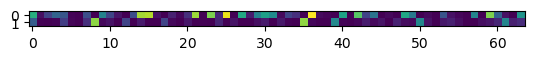

In [667]:
plt.imshow(linear_metrics['linear_ncmi'])

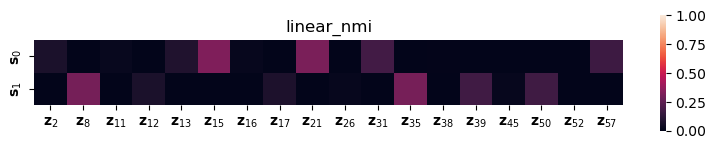

In [668]:
plot_mi_heatmap(linear_metrics, 'linear_nmi')
plt.savefig(f'./Figs/Entorhinal_NMI_{sampling_choice}.svg')

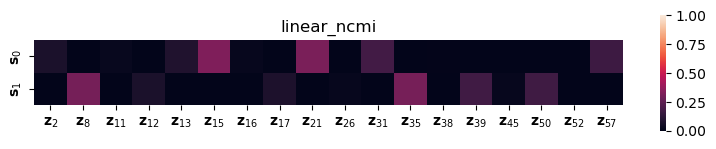

In [669]:
plot_mi_heatmap(linear_metrics, 'linear_ncmi')
plt.savefig(f'./Figs/Entorhinal_NCMI_{sampling_choice}.svg')

In [670]:
np.save('./data/PI_Learnt_Reps/source_example_kyle.npy', s)
np.save('./data/PI_Learnt_Reps/sink_example_kyle.npy', z)

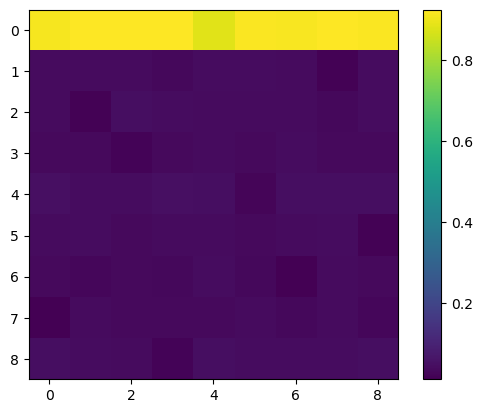

In [671]:
g = generate_rep(params_best, inputs, steoreotyped_actions)
plt.imshow(g[21,:,:])
plt.colorbar()

In [672]:
object_positions

array([[0, 0, 0, 1, 1, 1, 2, 2, 2],
       [0, 1, 2, 0, 1, 2, 0, 1, 2]])

In [673]:
positions

array([[[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2]]])

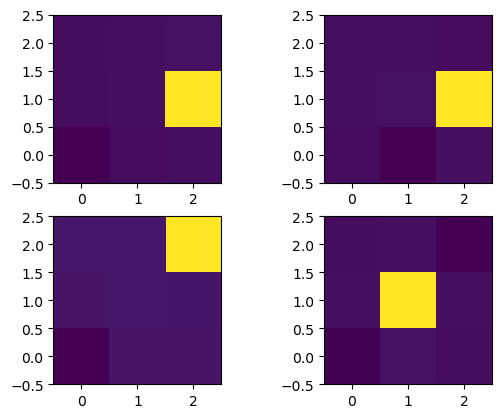

In [678]:
room1 = 4
room2 = 0
neuron1 = 31
neuron2 = 35

position_ordering = [0, 1, 2, 4, 5, 3, 8, 6, 7] 

plt.figure()
plt.subplot(2,2,1)
plt.imshow(np.reshape(g[neuron1,position_ordering,room1], [L,L]), origin='lower')
plt.subplot(2,2,2)
plt.imshow(np.reshape(g[neuron1,position_ordering,room2], [L,L]), origin='lower')

plt.subplot(2,2,3)
plt.imshow(np.reshape(g[neuron2,position_ordering,room1], [L,L]), origin='lower')
plt.subplot(2,2,4)
plt.imshow(np.reshape(g[neuron2,position_ordering,room2], [L,L]), origin='lower')


In [521]:
linear_metrics['linear_cinfom']

0.6170402631461114

(0.6, 1.0)

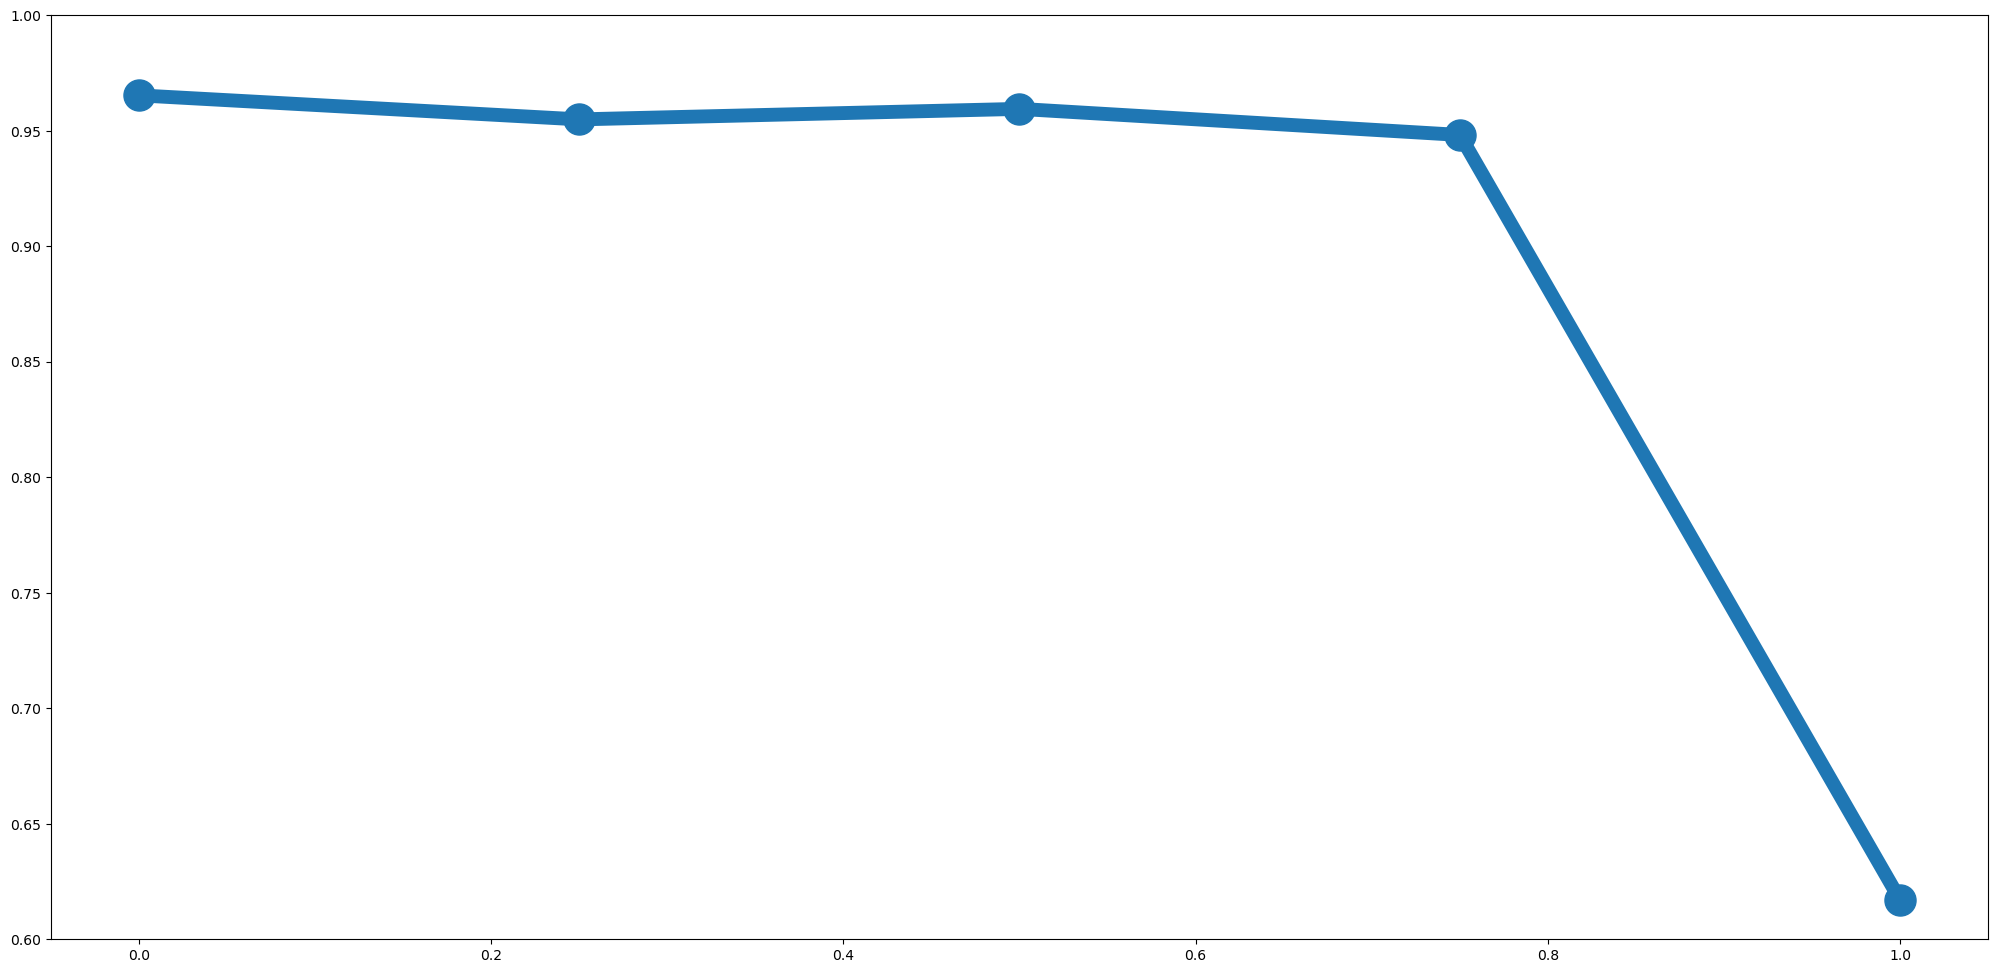

In [656]:
probs = 1-np.array([0, 0.25,0.5, 0.75, 1])
cinfoms = np.array([0.6170402631461114, 0.9481972968958017,0.9594811308033679,  0.9549277881791858, 0.9653385243211565])

plt.figure(figsize = (25,12))
plt.scatter(probs, cinfoms, s= 500)

plt.plot(probs, cinfoms, lw = 10)
plt.ylim([0.6, 1])